## Assignment2 - Supervised Learning flow

### Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [ ]:
# student 1:natanel 4697
# student 2:shaked 9553
# student 3:alon 8387
# student 4:daniel 6031
# student 5:oshrit 5303
# student 6:ilan 2224

## Part 2 - Experiments
You could add as many code cells as needed

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from google.colab import files
from sklearn.metrics import f1_score, make_scorer


# העלאת הקבצים
uploaded = files.upload()

# רשימת הקבצים שהועלו
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

# קריאת הקבצים שהועלו
cancer_train = pd.read_csv('cancer_train.csv')
cancer_test = pd.read_csv('cancer_test.csv')

# הצגת 5 השורות הראשונות של כל קובץ
print("Trainset:")
display(cancer_train.head().style.set_caption("Trainset"))

# Display the testset
print("\nTestset:")
display(cancer_test.head().style.set_caption("Testset"))


Saving cancer_test.csv to cancer_test.csv
Saving cancer_train.csv to cancer_train.csv
Uploaded file: cancer_test.csv
Uploaded file: cancer_train.csv
Trainset:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,13.170000,18.660000,85.980000,534.600000,0.115800,0.123100,0.122600,0.073400,0.212800,0.067770,0.287100,0.893700,1.897000,24.250000,0.006532,0.023360,0.029050,0.012150,0.017430,0.003643,15.670000,27.950000,102.800000,759.400000,0.178600,0.416600,0.500600,0.208800,0.390000,0.117900,0
1,9.667000,18.490000,61.490000,289.100000,0.089460,0.062580,0.029480,0.015140,0.223800,0.064130,0.377600,1.350000,2.569000,22.730000,0.007501,0.019890,0.027140,0.009883,0.019600,0.003913,11.140000,25.620000,70.880000,385.200000,0.123400,0.154200,0.127700,0.065600,0.317400,0.085240,1
2,20.090000,23.860000,134.700000,1247.000000,0.108000,0.183800,0.228300,0.128000,0.224900,0.074690,1.072000,1.743000,7.804000,130.800000,0.007964,0.047320,0.076490,0.019360,0.027360,0.005928,23.680000,29.430000,158.800000,1696.000000,0.134700,0.339100,0.493200,0.192300,0.329400,0.094690,0
3,8.950000,15.760000,58.740000,245.200000,0.094620,0.124300,0.092630,0.023080,0.130500,0.071630,0.313200,0.978900,3.280000,16.940000,0.018350,0.067600,0.092630,0.023080,0.023840,0.005601,9.414000,17.070000,63.340000,270.000000,0.117900,0.187900,0.154400,0.038460,0.165200,0.077220,1
4,18.030000,16.850000,117.500000,990.000000,0.089470,0.123200,0.109000,0.062540,0.172000,0.057800,0.298600,0.590600,1.921000,35.770000,0.004117,0.015600,0.029750,0.009753,0.012950,0.002436,20.380000,22.020000,133.300000,1292.000000,0.126300,0.266600,0.429000,0.153500,0.284200,0.082250,0



Testset:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,16.170000,16.070000,106.300000,788.500000,0.098800,0.143800,0.066510,0.053970,0.199000,0.065720,0.174500,0.489000,1.349000,14.910000,0.004510,0.018120,0.019510,0.011960,0.019340,0.003696,16.970000,19.140000,113.100000,861.500000,0.123500,0.255000,0.211400,0.125100,0.315300,0.089600,1
1,14.580000,13.660000,94.290000,658.800000,0.098320,0.089180,0.082220,0.043490,0.173900,0.056400,0.416500,0.623700,2.561000,37.110000,0.004953,0.018120,0.030350,0.008648,0.015390,0.002281,16.760000,17.240000,108.500000,862.000000,0.122300,0.192800,0.249200,0.091860,0.262600,0.070480,1
2,18.820000,21.970000,123.700000,1110.000000,0.101800,0.138900,0.159400,0.087440,0.194300,0.061320,0.819100,1.931000,4.493000,103.900000,0.008074,0.040880,0.053210,0.018340,0.023830,0.004515,22.660000,30.930000,145.300000,1603.000000,0.139000,0.346300,0.391200,0.170800,0.300700,0.083140,0
3,8.196000,16.840000,51.710000,201.900000,0.086000,0.059430,0.015880,0.005917,0.176900,0.065030,0.156300,0.956700,1.094000,8.205000,0.008968,0.016460,0.015880,0.005917,0.025740,0.002582,8.964000,21.960000,57.260000,242.200000,0.129700,0.135700,0.068800,0.025640,0.310500,0.074090,1
4,12.940000,16.170000,83.180000,507.600000,0.098790,0.088360,0.032960,0.023900,0.173500,0.062000,0.145800,0.905000,0.997500,11.360000,0.002887,0.012850,0.016130,0.007308,0.018700,0.001972,13.860000,23.020000,89.690000,580.900000,0.117200,0.195800,0.181000,0.083880,0.329700,0.078340,1


In [2]:
# טבלה 1: תיאור הנתונים ב-trainset
train_description = cancer_train.describe().style.format(precision=2)
print("\nTrainset Description:")
display(train_description)

# טבלה 2: התפלגות המטרות ב-trainset
train_target_distribution = cancer_train['target'].value_counts()
train_target_distribution_df = pd.DataFrame({'Count': train_target_distribution}).reset_index()
train_target_distribution_df.columns = ['Target', 'Count']

# שימוש ב-style להצגת הטבלה
styled_train_target_distribution = train_target_distribution_df.style.format(precision=0)
print("\nTrainset Target Distribution:")
display(styled_train_target_distribution.set_table_attributes('style="display:inline"').hide(axis="index"))



Trainset Description:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00,455.00
mean,14.26,19.48,92.88,668.58,0.10,0.11,0.09,0.05,0.18,0.06,0.42,1.21,2.94,42.18,0.01,0.03,0.03,0.01,0.02,0.00,16.45,25.91,108.56,903.10,0.13,0.26,0.28,0.12,0.29,0.08,0.61
std,3.61,4.26,24.92,364.59,0.01,0.05,0.08,0.04,0.03,0.01,0.30,0.51,2.15,49.19,0.00,0.02,0.03,0.01,0.01,0.00,4.98,6.15,34.62,594.10,0.02,0.16,0.21,0.07,0.06,0.02,0.49
min,6.98,10.38,43.79,143.50,0.05,0.02,0.00,0.00,0.12,0.05,0.11,0.36,0.76,7.23,0.00,0.00,0.00,0.00,0.01,0.00,7.93,12.49,50.41,185.20,0.08,0.03,0.00,0.00,0.16,0.06,0.00
25%,11.73,16.39,75.27,422.30,0.09,0.07,0.03,0.02,0.16,0.06,0.23,0.84,1.64,18.15,0.01,0.01,0.02,0.01,0.01,0.00,13.05,21.35,84.41,516.45,0.12,0.15,0.12,0.07,0.25,0.07,0.00
50%,13.46,19.02,87.16,559.20,0.10,0.09,0.06,0.03,0.18,0.06,0.32,1.13,2.33,24.62,0.01,0.02,0.03,0.01,0.02,0.00,14.99,25.50,97.67,697.70,0.13,0.22,0.23,0.10,0.28,0.08,1.00
75%,16.15,21.96,106.85,807.45,0.10,0.13,0.13,0.08,0.20,0.07,0.50,1.47,3.40,46.48,0.01,0.03,0.04,0.01,0.02,0.00,19.23,30.29,127.75,1151.50,0.15,0.34,0.39,0.16,0.32,0.09,1.00
max,28.11,39.28,188.50,2501.00,0.14,0.35,0.43,0.20,0.30,0.10,2.87,3.65,21.98,542.20,0.03,0.14,0.40,0.05,0.08,0.03,36.04,49.54,251.20,4254.00,0.22,1.06,1.17,0.29,0.58,0.21,1.00



Trainset Target Distribution:


Target,Count
1,277
0,178


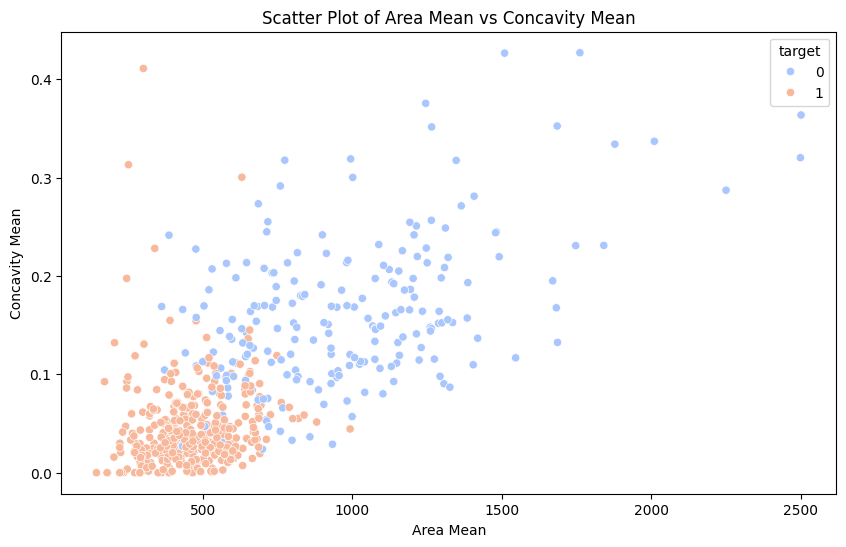

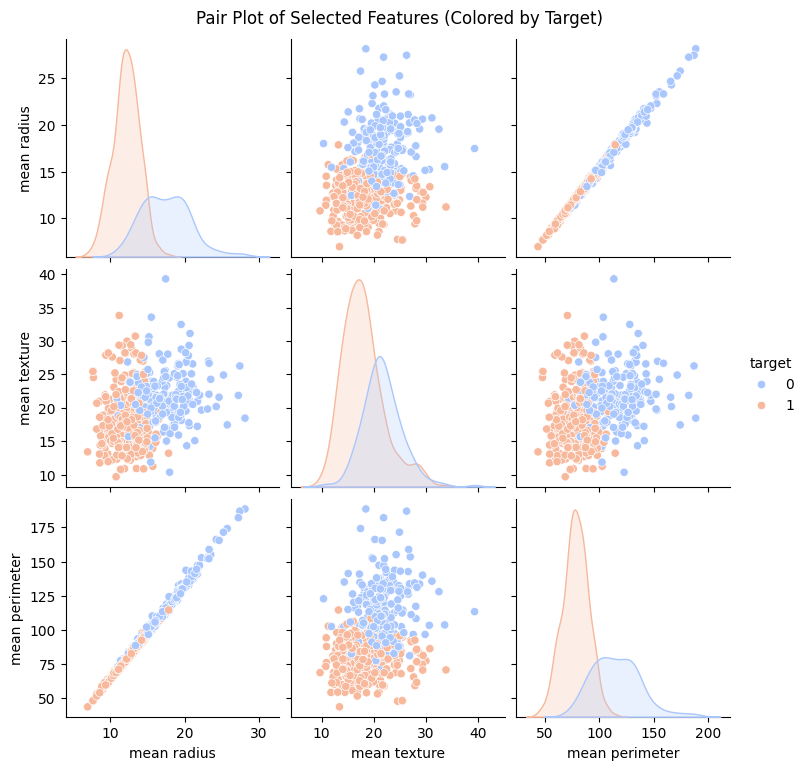

In [3]:
# Combining the train and test dataframes for comprehensive visualizations
cancer_data = pd.concat([cancer_train, cancer_test])

# Scatter Plot between two features
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cancer_data, x='mean area', y='mean concavity', hue='target', palette='coolwarm')
plt.title('Scatter Plot of Area Mean vs Concavity Mean')
plt.xlabel('Area Mean')
plt.ylabel('Concavity Mean')
plt.show()

# Pair Plot for three features
selected_features = ['mean radius', 'mean texture', 'mean perimeter']
pair_plot = sns.pairplot(cancer_data, hue='target', vars=selected_features, palette='coolwarm')
pair_plot.fig.suptitle("Pair Plot of Selected Features (Colored by Target)", y=1.02)
plt.show()

In [4]:
# Feature Engineering:יצירת מאפיין חדש - יחס בין שטח הגרעינים לקעירות
cancer_train['area_concave_ratio'] = cancer_train['mean area'] / (cancer_train['mean concave points'] + 1e-5)
cancer_test['area_concave_ratio'] = cancer_test['mean area'] / (cancer_test['mean concave points'] + 1e-5)

# Feature Engineering: יצירת מאפיין חדש - יחס בין רדיוס הגרעינים לקעירות
cancer_train['radius_concavity_ratio'] = cancer_train['mean radius'] / (cancer_train['mean concavity'] + 1e-5)
cancer_test['radius_concavity_ratio'] = cancer_test['mean radius'] / (cancer_test['mean concavity'] + 1e-5)

# שמירת עמודת ה-Target
train_target = cancer_train['target']
test_target = cancer_test['target']

# הסרת עמודת ה-Target לצורך סטנדרטיזציה אחידה
cancer_train_no_target = cancer_train.drop(columns=['target'])
cancer_test_no_target = cancer_test.drop(columns=['target'])

# שילוב של ה-Train וה-Test לצורך סטנדרטיזציה אחידה
combined_data = pd.concat([cancer_train_no_target, cancer_test_no_target], axis=0)

# סטנדרטיזציה
scaler = MinMaxScaler(feature_range=(0, 1))
features_to_scale = combined_data.columns

# החלת הסטנדרטיזציה על הנתונים המשולבים
combined_data[features_to_scale] = scaler.fit_transform(combined_data[features_to_scale])

# הפרדת ה-Train וה-Test לאחר סטנדרטיזציה
cancer_train_scaled = combined_data.iloc[:len(cancer_train), :].copy()
cancer_test_scaled = combined_data.iloc[len(cancer_train):, :].copy()

# הוספת עמודת ה-Target חזרה
cancer_train_scaled['target'] = train_target.values
cancer_test_scaled['target'] = test_target.values

# מציגים את הנתונים לאחר Feature Engineering
display(cancer_train_scaled.head().style.set_caption("Trainset after Feature Engineering - first 5 rows:"))
print("\n")

display(cancer_test_scaled.head().style.set_caption("Testset after Feature Engineering - first 5 rows:"))
print("\n")

# הצגת ערכים מינימליים ומקסימליים לאחר סטנדרטיזציה
train_min = cancer_train_scaled[features_to_scale].min()
train_max = cancer_train_scaled[features_to_scale].max()

test_min = cancer_test_scaled[features_to_scale].min()
test_max = cancer_test_scaled[features_to_scale].max()

metrics_df = pd.DataFrame({'Train Min': train_min, 'Train Max': train_max, 'Test Min': test_min, 'Test Max': test_max})

display(metrics_df.style.set_caption("Metrics after Min-Max Scaling:"))


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,area_concave_ratio,radius_concavity_ratio,target
0,0.292915,0.302672,0.291549,0.165896,0.570281,0.318140,0.287254,0.364811,0.539394,0.375105,0.063589,0.117906,0.053715,0.032589,0.163817,0.158530,0.073359,0.230157,0.134350,0.094945,0.275347,0.424574,0.260919,0.141123,0.709437,0.377711,0.399840,0.717526,0.460280,0.412305,0.000078,0.000068,0
1,0.127124,0.296923,0.122314,0.061760,0.332491,0.132507,0.069072,0.075249,0.594949,0.298441,0.096361,0.218750,0.085379,0.029750,0.196757,0.132469,0.068535,0.187213,0.164884,0.104273,0.114194,0.362473,0.101947,0.049155,0.344912,0.123129,0.101997,0.225430,0.317169,0.198085,0.000331,0.000248,1
2,0.620427,0.478526,0.628222,0.468081,0.499865,0.504325,0.534911,0.636183,0.600505,0.520851,0.347818,0.305605,0.332045,0.231600,0.212496,0.338480,0.193157,0.366736,0.274076,0.173887,0.560299,0.464019,0.539818,0.371313,0.419534,0.302520,0.393930,0.660825,0.340824,0.260068,0.000130,0.000052,0
3,0.093189,0.204599,0.103310,0.043139,0.379074,0.321821,0.217034,0.114712,0.123737,0.456403,0.073040,0.136735,0.118880,0.018935,0.565557,0.490792,0.233914,0.437204,0.224546,0.162590,0.052793,0.134595,0.064396,0.020842,0.308591,0.155825,0.123323,0.132165,0.017150,0.145481,0.000149,0.000059,1
4,0.522931,0.241461,0.509364,0.359067,0.332581,0.318447,0.255389,0.310835,0.333333,0.165122,0.067753,0.050919,0.054846,0.054106,0.081721,0.100249,0.075126,0.184751,0.071312,0.053245,0.442903,0.266525,0.412819,0.272021,0.364063,0.232180,0.342652,0.527491,0.251725,0.178473,0.000261,0.000115,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,area_concave_ratio,radius_concavity_ratio,target
0,0.434900,0.215083,0.431967,0.273595,0.416810,0.381633,0.155834,0.268241,0.469697,0.331929,0.022814,0.028465,0.027894,0.015144,0.095081,0.119176,0.049268,0.226558,0.161226,0.096776,0.321594,0.189765,0.312217,0.166216,0.345572,0.220925,0.168850,0.429897,0.313030,0.226682,0.000235,0.000179,1
1,0.359648,0.133581,0.348974,0.218579,0.412476,0.214097,0.192643,0.216153,0.342929,0.135636,0.110447,0.058235,0.085002,0.056608,0.110140,0.119176,0.076641,0.163819,0.105645,0.047890,0.314123,0.139126,0.289307,0.166339,0.337648,0.160579,0.199042,0.315670,0.209146,0.101272,0.000247,0.000125,1
2,0.560320,0.414609,0.552208,0.409968,0.443893,0.366603,0.373477,0.434592,0.445960,0.239259,0.256238,0.347153,0.176035,0.181357,0.216236,0.290113,0.134369,0.347414,0.224405,0.125071,0.524013,0.503998,0.472583,0.348457,0.447930,0.309505,0.312460,0.586942,0.284250,0.184311,0.000194,0.000077,0
3,0.057504,0.241123,0.054730,0.024772,0.301255,0.122845,0.037207,0.029409,0.358081,0.317397,0.016223,0.131829,0.015879,0.002620,0.246626,0.106708,0.040101,0.112086,0.251280,0.058289,0.036784,0.264925,0.034115,0.014009,0.386515,0.105180,0.054952,0.088110,0.303568,0.124951,0.000653,0.000401,1
4,0.282029,0.218465,0.272200,0.154443,0.416719,0.211582,0.077226,0.118787,0.340909,0.253580,0.012421,0.120403,0.011332,0.008513,0.039909,0.079596,0.040732,0.138435,0.152220,0.037215,0.210957,0.293177,0.195627,0.097252,0.303969,0.163489,0.144569,0.288247,0.341415,0.152827,0.000377,0.000301,1


,Train Min,Train Max,Test Min,Test Max
mean radius,0.000000,1.000000,0.057504,0.771878
mean texture,0.022658,1.000000,0.000000,0.710517
mean perimeter,0.000000,1.000000,0.054730,0.795453
mean area,0.000000,1.000000,0.024772,0.653871
mean smoothness,0.000000,0.831182,0.141284,1.000000
mean compactness,0.000000,1.000000,0.012453,0.811361
mean concavity,0.000000,1.000000,0.000000,0.825445
mean concave points,0.000000,1.000000,0.000000,0.805169
mean symmetry,0.054040,1.000000,0.000000,0.776263
mean fractal dimension,0.000000,0.964406,0.039806,1.000000


In [5]:
# Ensure data is in the correct format
X_train = cancer_train_scaled.drop(columns=['target']).values
y_train = cancer_train_scaled['target'].values
X_test = cancer_test_scaled.drop(columns=['target']).values
y_test = cancer_test_scaled['target'].values

# K-Nearest Neighbors
knn_params = [3, 5, 7, 9, 11]
for k in knn_params:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'KNN with k={k}: Accuracy = {accuracy:.4f}')

# Decision Tree
tree_params = [5, 10, 15, 20, 25]
for depth in tree_params:
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Decision Tree with max_depth={depth}: Accuracy = {accuracy:.4f}')

# Logistic Regression
logreg_params = [0.01, 0.1, 1.0, 10.0, 100.0]
for C in logreg_params:
    logreg = LogisticRegression(C=C, max_iter=1000)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Logistic Regression with C={C}: Accuracy = {accuracy:.4f}')


KNN with k=3: Accuracy = 0.9649
KNN with k=5: Accuracy = 0.9649
KNN with k=7: Accuracy = 0.9649
KNN with k=9: Accuracy = 0.9737
KNN with k=11: Accuracy = 0.9737
Decision Tree with max_depth=5: Accuracy = 0.9474
Decision Tree with max_depth=10: Accuracy = 0.9211
Decision Tree with max_depth=15: Accuracy = 0.9561
Decision Tree with max_depth=20: Accuracy = 0.9386
Decision Tree with max_depth=25: Accuracy = 0.9474
Logistic Regression with C=0.01: Accuracy = 0.8421
Logistic Regression with C=0.1: Accuracy = 0.9649
Logistic Regression with C=1.0: Accuracy = 0.9737
Logistic Regression with C=10.0: Accuracy = 0.9912
Logistic Regression with C=100.0: Accuracy = 0.9737


In [9]:
# Define different feature sets
feature_sets = {
    'Without_New_Features': cancer_train_scaled.drop(columns=['target', 'area_concave_ratio', 'radius_concavity_ratio']),
    'With_Area_Concave_Ratio': cancer_train_scaled.drop(columns=['target', 'radius_concavity_ratio']),
    'With_Radius_Concavity_Ratio': cancer_train_scaled.drop(columns=['target', 'area_concave_ratio']),
    'With_Both_New_Features': cancer_train_scaled.drop(columns=['target'])
}

# Prepare the test datasets accordingly
test_feature_sets = {
    'Without_New_Features': cancer_test_scaled.drop(columns=['target', 'area_concave_ratio', 'radius_concavity_ratio']),
    'With_Area_Concave_Ratio': cancer_test_scaled.drop(columns=['target', 'radius_concavity_ratio']),
    'With_Radius_Concavity_Ratio': cancer_test_scaled.drop(columns=['target', 'area_concave_ratio']),
    'With_Both_New_Features': cancer_test_scaled.drop(columns=['target'])
}

# Define the models and parameter grids
models = {
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

param_grids = {
    'KNN': {'n_neighbors': [3, 5, 7, 9, 11]},
    'DecisionTree': {'max_depth': [5, 10, 15, 20, 25]},
    'LogisticRegression': {'C': [0.1, 1.0, 10.0, 15.0, 20.0]}
}

# Define the scorer
scorer = make_scorer(f1_score, average='macro')

# Perform Grid Search with 5-fold Cross-Validation for each feature set and model
best_estimators = {}
results = []

for feature_set_name, X_train_df in feature_sets.items():
    X_train = np.ascontiguousarray(X_train_df)
    y_train = np.ascontiguousarray(cancer_train_scaled['target'])
    X_test = np.ascontiguousarray(test_feature_sets[feature_set_name])
    y_test = np.ascontiguousarray(cancer_test_scaled['target'])

    for model_name in models:
        print(f"Running GridSearchCV for {model_name} on {feature_set_name}")
        grid_search = GridSearchCV(models[model_name], param_grids[model_name], scoring=scorer, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_estimators[(model_name, feature_set_name)] = grid_search.best_estimator_

        # Perform 5-fold cross-validation on the best estimator
        cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring=scorer)
        avg_cv_score = cv_scores.mean()

        y_pred = grid_search.best_estimator_.predict(X_test)
        test_score = f1_score(y_test, y_pred, average='macro')


        results.append({
            'Model': model_name,
            'Feature Set': feature_set_name,
            'Best Params': grid_search.best_params_,
            'Best CV Score': avg_cv_score,
            'Test F1-Macro Score': test_score
              })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the summary table
display(results_df.style.set_caption("summary of Grid Search results:"))

Running GridSearchCV for KNN on Without_New_Features
Running GridSearchCV for DecisionTree on Without_New_Features
Running GridSearchCV for LogisticRegression on Without_New_Features
Running GridSearchCV for KNN on With_Area_Concave_Ratio
Running GridSearchCV for DecisionTree on With_Area_Concave_Ratio
Running GridSearchCV for LogisticRegression on With_Area_Concave_Ratio
Running GridSearchCV for KNN on With_Radius_Concavity_Ratio
Running GridSearchCV for DecisionTree on With_Radius_Concavity_Ratio
Running GridSearchCV for LogisticRegression on With_Radius_Concavity_Ratio
Running GridSearchCV for KNN on With_Both_New_Features
Running GridSearchCV for DecisionTree on With_Both_New_Features
Running GridSearchCV for LogisticRegression on With_Both_New_Features


,Model,Feature Set,Best Params,Best CV Score,Test F1-Macro Score
0,KNN,Without_New_Features,{'n_neighbors': 7},0.962890,0.958088
1,DecisionTree,Without_New_Features,{'max_depth': 5},0.919315,0.948865
2,LogisticRegression,Without_New_Features,{'C': 15.0},0.972176,0.989609
3,KNN,With_Area_Concave_Ratio,{'n_neighbors': 7},0.962890,0.958088
4,DecisionTree,With_Area_Concave_Ratio,{'max_depth': 5},0.919460,0.928411
5,LogisticRegression,With_Area_Concave_Ratio,{'C': 15.0},0.972176,0.989609
6,KNN,With_Radius_Concavity_Ratio,{'n_neighbors': 7},0.962890,0.958088
7,DecisionTree,With_Radius_Concavity_Ratio,{'max_depth': 5},0.907856,0.938156
8,LogisticRegression,With_Radius_Concavity_Ratio,{'C': 15.0},0.972176,0.989609
9,KNN,With_Both_New_Features,{'n_neighbors': 7},0.962890,0.958088


## Part 3 - Training flow
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 2)

In [ ]:
X_train = cancer_train_scaled.drop(columns=['target'])
y_train = cancer_train_scaled['target']
X_test = cancer_test_scaled.drop(columns=['target'])
y_test = cancer_test_scaled['target']

# Define and fit the Logistic Regression model with C=10
logreg = LogisticRegression(C=15, max_iter=1000)
logreg.fit(X_train, y_train)

## Part 4 - Apply on test and show model performance estimation

In [ ]:
 # Predict on the test set
y_pred = logreg.predict(X_test)

# Display the first few predictions
print()
first_few_predictions = pd.DataFrame({
    'Actual': y_test[:10],
    'Predicted': y_pred[:10]
})
display(first_few_predictions.style.set_caption("First few classifications on the test set:").set_table_attributes('style="display:inline"').hide(axis="index"))

# Calculate and print the F1-Macro Score and accuracy
f1_macro_score = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

print(f'\nLogistic Regression with C=15: F1-Macro Score = {f1_macro_score:.4f}')
print(f'Logistic Regression with C=15: Accuracy = {accuracy:.4f}')


Actual,Predicted
1,1
1,1
0,0
1,1
1,1
1,1
0,0
1,1
1,1
1,1



Logistic Regression with C=15: F1-Macro Score = 0.9896
Logistic Regression with C=15: Accuracy = 0.9912
